In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

Check Type Casting Gradient
===

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.special import erfinv
import seaborn as sns

In [3]:
X = np.load('type_cast_grad.npy')
X.shape

(12, 11, 360, 480)

In [4]:
# we only sample one of its batches
X = X[0]

In [37]:
def log_abs_nnz(X):
    return np.log(np.abs(X[X != 0]))

## Plot distribution

In [33]:
def plot_dist_in_log(ax, X, label=None):
    """ Plot the distribution in the log space """
    log_X = log_abs_nnz(X)
    
    hist, bin_edges = np.histogram(log_X, bins=100)
    ax.plot(bin_edges[1:], hist / log_X.size, label=label)

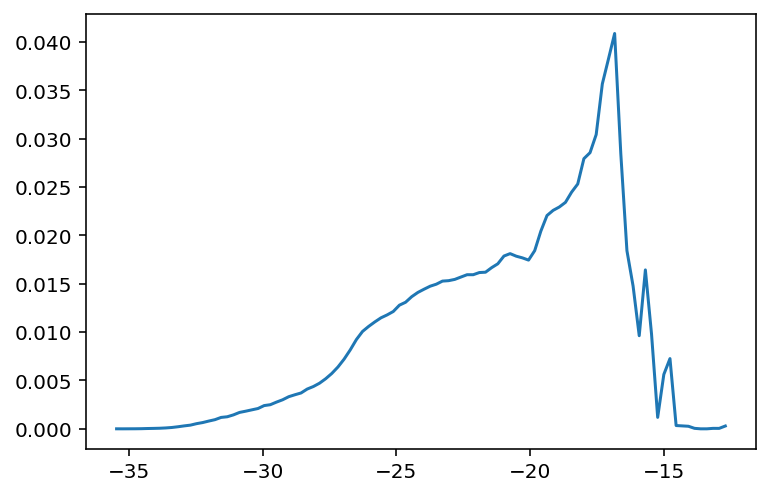

In [38]:
fig, ax = plt.subplots()
plot_dist_in_log(ax, X)

## Try to fit X

In [39]:
def gen_log_normal(X):
    """ We assume X is from a lognormal distribution """
    log_X = log_abs_nnz(X)
    mu, sigma = np.mean(log_X), np.std(log_X)
    
    log_Y = np.random.normal(mu, sigma, size=log_X.size)
    Y = np.exp(log_Y)
    return Y

In [40]:
def gen_normal(X):
    """ Assuming X is normal distributrion. """
    mu, sigma = np.mean(X), np.std(X)
    
    Y = np.random.normal(mu, sigma, size=X.size)
    return Y

Text(0, 0.5, 'Percentage')

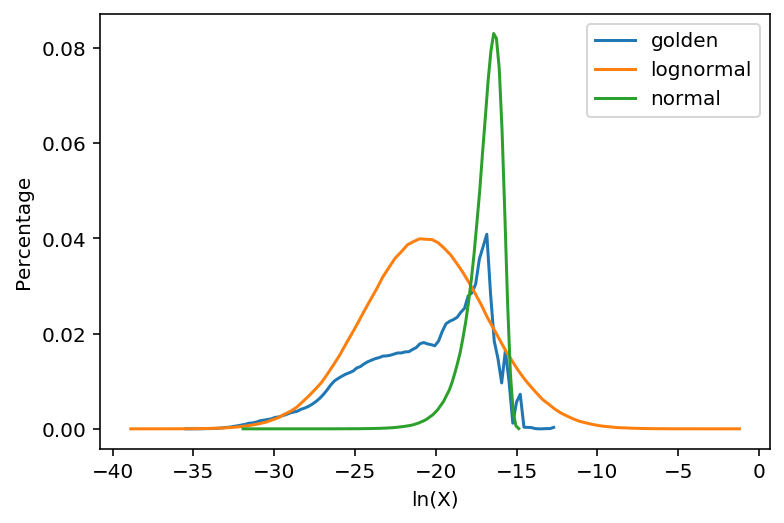

In [95]:
Y = gen_log_normal(X)
Z = gen_normal(X)

fig, ax = plt.subplots()
plot_dist_in_log(ax, X, label='golden')
plot_dist_in_log(ax, Y, label='lognormal')
plot_dist_in_log(ax, Z, label='normal')

ax.legend()
ax.set_xlabel('ln(X)')
ax.set_ylabel('Percentage')

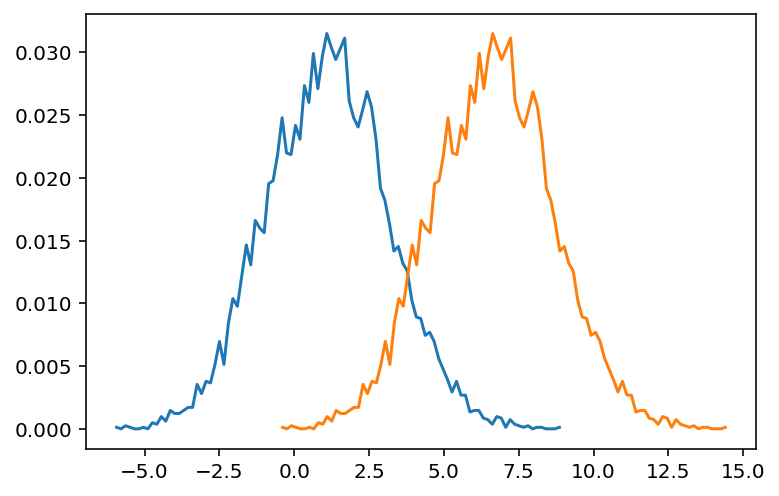

In [92]:
# Scale lognormal distribution
Y = np.random.lognormal(1, 2, size=8192)
Z = Y * 256

fig, ax = plt.subplots()
plot_dist_in_log(ax, Y, label='lognormal')
plot_dist_in_log(ax, Z, label='lognormal')

## Calculate scale

In [89]:
def get_scale_by_lognormal(X, u_min=6e-8, thres=1e-3):
    """ Calculate gradient scale by the lognormal assumption """
    log_X = log_abs_nnz(X)
    mu, sigma = np.mean(log_X), np.std(log_X)
    
    log_scale = np.log(u_min) - mu - sigma * np.sqrt(2) * erfinv(2 * thres - 1)
    return np.exp(log_scale)

In [90]:
def get_ufr(X):
    nnz_fp32 = np.count_nonzero(X) / X.size
    nnz_fp16 = np.count_nonzero(X.astype(np.float16)) / X.size
    return nnz_fp32 - nnz_fp16

scale = 8902626.556430
Underflow rate:
Before: 0.782292
After:  0.000442


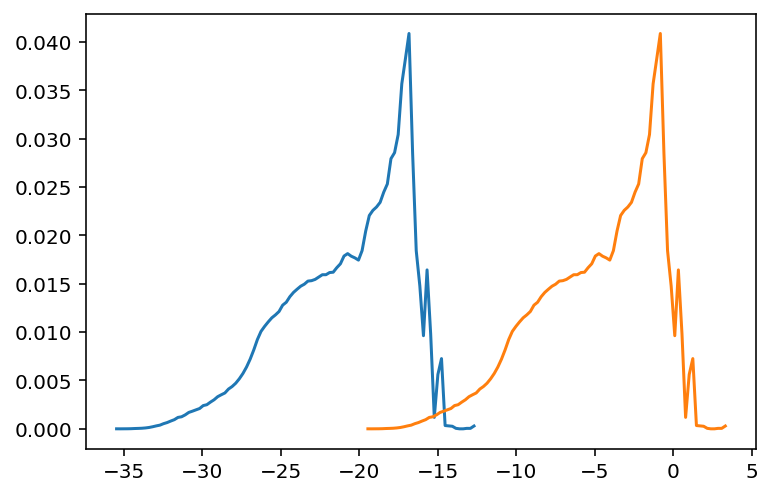

In [91]:
alpha = get_scale_by_lognormal(X)
print('scale = {:.6f}'.format(alpha))

print('Underflow rate:')
print('Before: {:.6f}'.format(get_ufr(X)))
print('After:  {:.6f}'.format(get_ufr(alpha * X)))

fig, ax = plt.subplots()
plot_dist_in_log(ax, X)
plot_dist_in_log(ax, alpha * X)